# Classification Analysis for ECG Time-Series

> Copyright 2019 Dave Fernandes. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
> http://www.apache.org/licenses/LICENSE-2.0
>  
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

## Overview
This notebook classifies time-series for segmented heartbeats from ECG lead II recordings. Either of two models (CNN or RNN) can be selected from training and evaluation.
- Data for this analysis should be prepared using the `PreprocessECG.ipynb` notebook from this project.
- Original data is from: https://www.kaggle.com/shayanfazeli/heartbeat

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as keras
import matplotlib.pyplot as plt
import pickle

tf.enable_eager_execution()

TRAIN_SET = './Data/train_set.pickle'
TEST_SET = './Data/test_set.pickle'

with open(TEST_SET, 'rb') as file:
    test_set = pickle.load(file)
    x_test = test_set['x']
    y_test = test_set['y']

with open(TRAIN_SET, 'rb') as file:
    train_set = pickle.load(file)
    x_train = train_set['x']
    y_train = train_set['y']
    
def parameter_count():
    total = 0
    for v in tf.trainable_variables():
        v_elements = 1
        for dim in v.get_shape():
            v_elements *= dim.value

        total += v_elements
    return total

### Input functions for Estimator

In [3]:
def combined_dataset(features, labels):
    assert features.shape[0] == labels.shape[0]
    dataset = tf.data.Dataset.from_tensor_slices(({'time_series': features}, labels))
    return dataset

def class_for_element(features, labels):
    return labels

# For training
def train_input_fn():
    dataset = combined_dataset(x_train, y_train)
    return dataset.repeat().shuffle(500000).batch(200).prefetch(1)

# For evaluation and metrics
def eval_input_fn():
    dataset = combined_dataset(x_test, y_test)
    return dataset.batch(1000).prefetch(1)

### Define the models
#### Convolutional Model
* The convolutional model is taken from: https://arxiv.org/pdf/1805.00794.pdf

Model consists of:
* An initial 1-D convolutional layer
* 5 repeated residual blocks (`same` padding)
* A fully-connected layer
* A linear layer with softmax output

In [4]:
CNN_MODEL_DIR = './Models/CNN-Paper'

def conv_unit(unit, input_layer):
    s = '_' + str(unit)
    layer = keras.Conv1D(name='Conv1' + s, filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)
    layer = keras.Conv1D(name='Conv2' + s, filters=32, kernel_size=5, strides=1, padding='same', activation=None)(layer )
    layer = keras.Add(name='ResidualSum' + s)([layer, input_layer])
    layer = keras.Activation("relu", name='Act' + s)(layer)
    layer = keras.MaxPooling1D(name='MaxPool' + s, pool_size=5, strides=2)(layer)
    return layer

def cnn_model(input_layer, mode, params):
    current_layer = keras.Conv1D(filters=32, kernel_size=5, strides=1)(input_layer)

    for i in range(5):
        current_layer = conv_unit(i + 1, current_layer)

    current_layer = keras.Flatten()(current_layer)
    current_layer = keras.Dense(32, name='FC1', activation='relu')(current_layer)
    logits = keras.Dense(5, name='Output')(current_layer)
    
    print('Parameter count:', parameter_count())
    return logits

#### Recurrent Model

Model consists of:
* Two stacked bidirectional GRU layers
* Two fully-connected layers
* A linear layer with softmax output

Since the model operates on segmented heartbeat samples, we can use a bidirectional RNN because the whole segment is available for processing at one time. It is also a more \"fair\" comparison with the CNN.

In [5]:
RNN_MODEL_DIR = './Models/RNN'
RNN_OUTPUT_UNITS = [64, 128]

def rnn_model(input_layer, mode, params):
    current_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(187, 1), name='Masked')(input_layer)
    
    for i, size in enumerate(RNN_OUTPUT_UNITS):
        notLast = i + 1 < len(RNN_OUTPUT_UNITS)
        layer = tf.keras.layers.GRU(size, return_sequences=notLast, dropout=0.2, name = 'GRU' + str(i+1))
        current_layer = keras.Bidirectional(layer, name = 'BiRNN' + str(i+1))(current_layer)

    current_layer = keras.Dense(64, name='Dense1', activation='relu')(current_layer)
    current_layer = keras.Dense(16, name='Dense2', activation='relu')(current_layer)
    logits = keras.Dense(5, name='Output', activation='relu')(current_layer)
    
    print('Parameter count:', parameter_count())
    return logits

### Estimator setup

In [6]:
# Initial learning rate
INITIAL_LEARNING_RATE = 0.001

# Learning rate decay per LR_DECAY_STEPS steps (1.0 = no decay)
LR_DECAY_RATE = 0.5

# Number of steps for LR to decay by LR_DECAY_RATE
LR_DECAY_STEPS = 4000

# Threshold for gradient clipping
GRADIENT_NORM_THRESH = 10.0

# Select model to train
MODEL_DIR = CNN_MODEL_DIR
MODEL_FN = cnn_model

def classifier_fn(features, labels, mode, params):
    is_training = mode == tf.estimator.ModeKeys.TRAIN
    input_layer = tf.feature_column.input_layer(features, params['feature_columns'])
    input_layer = tf.expand_dims(input_layer, -1)

    logits = MODEL_FN(input_layer, mode, params)

    # For prediction, exit here
    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # For training and evaluation, compute the loss (MSE)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes, name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

    # For training...
    global_step = tf.train.get_global_step()
    learning_rate = tf.train.exponential_decay(INITIAL_LEARNING_RATE, global_step, LR_DECAY_STEPS, LR_DECAY_RATE)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, GRADIENT_NORM_THRESH)
    
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

### Train model

In [7]:
feature_columns = [tf.feature_column.numeric_column('time_series', [187])]

estimator = tf.estimator.Estimator(
    model_fn=classifier_fn,
    model_dir=MODEL_DIR,
    params={
        'feature_columns': feature_columns,
    })

estimator.train(train_input_fn, steps=4000)
info = estimator.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './Models/CNN-Paper', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000019BAB8811C8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized autom

INFO:tensorflow:Finished evaluation at 2021-03-26-00:08:05
INFO:tensorflow:Saving dict for global step 4000: accuracy = 0.952, global_step = 4000, loss = 0.21512417
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: ./Models/CNN-Paper\model.ckpt-4000


### Compute metrics

INFO:tensorflow:Calling model_fn.
Parameter count: 53957
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Models/CNN-Paper\model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       100
           1       0.97      0.95      0.96       100
           2       0.91      0.97      0.94       100
           3       1.00      0.87      0.93       100
           4       1.00      0.98      0.99       100

    accuracy                           0.95       500
   macro avg       0.96      0.95      0.95       500
weighted avg       0.96      0.95      0.95       500



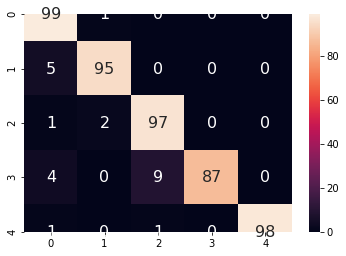

In [8]:
import sklearn.metrics as skm
import seaborn

dataset_fn = eval_input_fn

predictions = estimator.predict(input_fn=dataset_fn)
y_pred = []
y_prob = []

for i, value in enumerate(predictions):
    class_id = value['class_ids']
    y_pred.append(class_id)
    probabilities = value['probabilities']
    y_prob.append(probabilities[class_id])
del predictions

y_pred = np.array(y_pred)
y_prob = np.array(y_prob)
y_test = np.reshape(y_test, (len(y_test), 1))

# Classification report
report = skm.classification_report(y_test, y_pred)
print(report)

# Confusion matrix
cm = skm.confusion_matrix(y_test, y_pred)
seaborn.heatmap(cm, annot=True,annot_kws={"size": 16})

y_prob_correct = y_prob[y_pred == y_test]
y_prob_mis = y_prob[y_pred != y_test]

### Check probability estimates

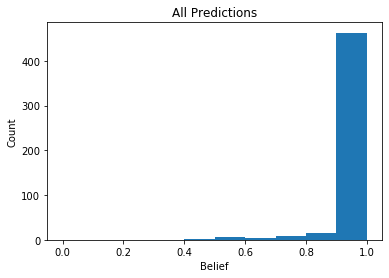

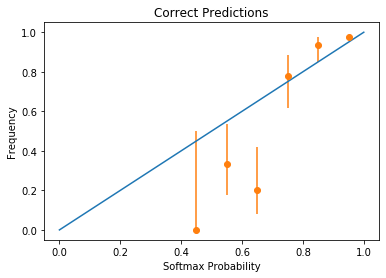

In [9]:
from astropy.stats import binom_conf_interval

_, _, _ = plt.hist(y_prob, 10, (0, 1))
plt.xlabel('Belief')
plt.ylabel('Count')
plt.title('All Predictions')
plt.show();

n_all, bins = np.histogram(y_prob, 10, (0, 1))
n_correct, bins = np.histogram(y_prob_correct, 10, (0, 1))

f_correct = n_correct / np.clip(n_all, 1, None)
f_bins = 0.5 * (bins[:-1] + bins[1:])

n_correct = n_correct[n_all > 0]
n_total = n_all[n_all > 0]
f_correct = n_correct / n_total
f_bins = f_bins[n_all > 0]

lower_bound, upper_bound = binom_conf_interval(n_correct, n_total)
error_bars = np.array([f_correct - lower_bound, upper_bound - f_correct])

plt.plot([0., 1.], [0., 1.])
plt.errorbar(f_bins, f_correct, yerr=error_bars, fmt='o')
plt.xlabel('Softmax Probability')
plt.ylabel('Frequency')
plt.title('Correct Predictions')
plt.show();